# Proof of Concept (PoC)

Building QMARL with entangled agents.

In [2]:
from cirq.contrib.svg import SVGCircuit, circuit_to_svg
from pathlib import Path
from typing import Any, Callable, Generator, Iterable
import cirq
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy

In [3]:
# This flag globally disables all quantum circuit tests within the function `test_runner` (defined below).
# Use this flag to prevent lots of tests from running and taking up significant execution time.
GLOBAL_TEST_FLAG = False

In [4]:
plt.ioff() # Turn off automatic showing of plots (must explicitly show plots).

## Experiment functions

In [5]:
def plot_state_histogram_all(samples, axis, d: int, n: int, key: str = 'all', color: str|tuple[float, float, float] = None):
    hist_all = samples.histogram(key=key)
    df_hist_all = pd.DataFrame.from_records([hist_all], columns=list(range(2**(d*n)))).melt(value_vars=list(range(2**(d*n)))).rename(columns={'variable': 'qubit state', 'value': 'result count'})
    if color is None:
        color = sns.color_palette()[0]
    sns.barplot(df_hist_all, x='qubit state', y='result count', ax=axis, color=color)
    ctr = samples.histogram(key=key)
    mean = np.mean([v for k, v in ctr.items()])
    std = np.std([v for k, v in ctr.items()])
    axis.axhline(y=mean, color='red', linestyle='--', label='mean')
    axis.axhline(y=mean+std, color='green', linestyle='--', label='mean+std')
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    axis.xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
    axis.legend()
    return axis


def plot_state_histogram_agents(samples, axis, d: int, n: int, key_prefix: str = 'agent', colors: list[str|tuple[float,float,float]] = None):
    hist_agents = [samples.histogram(key=f"{key_prefix}{k}") for k in range(n)]
    df_hist_agents = pd.DataFrame.from_records(hist_agents, columns=list(range(2**d)))
    df_hist_agents = df_hist_agents\
        .rename_axis(index='agent')\
        .reset_index()\
        .melt(id_vars='agent', value_vars=list(range(2**d)))\
        .rename(columns={'variable': 'qubit state', 'value': 'result count'})
    if colors is None:
        colors = sns.color_palette()[1:] # Remove first one because it is assumed to be reserved for the "all" plot.
    sns.barplot(df_hist_agents, x='qubit state', y='result count', hue='agent', ax=axis, palette=colors)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    axis.xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d}b}")
    return axis

In [131]:
def build_parameterized_system_circuit(
    d: int, 
    n: int, 
    policy_fn: Callable[[list[cirq.LineQubit], int], tuple[Iterable[Any], list[list[sympy.Symbol]]]],
    entangle_fn: Callable[[list, int, int], Any] = None,
    meas_key_all: str = 'all',
    meas_key_prefix_agent: str = 'agent',
    meas_flag: bool = True, # Denotes whether to perform measurements (True) or not (False).
    ) -> tuple[cirq.Circuit, list[list[list[sympy.Symbol]]]]:
    """Constructs an parameterized circuit representing the entire system (all agents).
    """
    qubits = cirq.LineQubit.range(d * n)
    circuit = cirq.Circuit()
    # var_thetas, enc_inputs = [], []
    symbol_list = []
    if entangle_fn is not None:
        circuit.append(entangle_fn(qubits, d, n))
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        
        # Policy circuit.
        # agent_circuit_gen_fn, agent_symbol_list = parameterized_variational_encoding_policy_circuit(qubits[qidx:qidx+d], n_layers, symbol_superscript_index=aidx)
        agent_circuit_gen_fn, agent_symbol_list = policy_fn(qubits[qidx:qidx+d], aidx)
        symbol_list.append(agent_symbol_list) # Preserve symbols for agent.
        # var_thetas.append(agent_var_thetas) # Preserve symbols for agent.
        # enc_inputs.append(agent_enc_inputs) # Preserve symbols for agent.
        circuit.append(agent_circuit_gen_fn())
        
        # Measure (only if requested).
        if meas_flag: circuit.append(cirq.measure(qubits[qidx:qidx+d], key=f"{meas_key_prefix_agent}{aidx}")) # Measure agent qubits.
    if meas_flag: circuit.append(cirq.measure(qubits, key=meas_key_all)) # Store measurement of entire system circuit.
    return circuit, symbol_list

In [7]:
def simulate_parameterized_circuit(
    circuit: cirq.Circuit,
    symbol_dict: dict,
    repetitions: int = 100,
    ) -> tuple[float, dict]:
    param_resolver = cirq.ParamResolver(symbol_dict)

    # Compute entanglement entropy of output state.
    extra_data_fields = {}
    extra_data_fields['rho'] = cirq.final_density_matrix(circuit, param_resolver=param_resolver)
    extra_data_fields['entropy'] = cirq.von_neumann_entropy(extra_data_fields['rho'])
    
    # Simulate circuit and generate histogram of measurement outcomes.
    sim = cirq.Simulator()
    samples = sim.run(circuit, repetitions=repetitions, param_resolver=param_resolver)
    return samples, extra_data_fields

In [132]:
def test_runner(
    d: int,
    n: int,
    policy_fn: Callable[[list[cirq.LineQubit], int], tuple[Iterable[Any], list[list]]],
    symbol_resolver_fn: Callable[..., dict] = None,
    figure_kwargs: dict = dict(layout='constrained', figsize=(20,14)),
    subfigure_kwargs: dict = dict(nrows=2, ncols=2, wspace=0.09, hspace=0.09),
    figure_title: str = None,
    repetitions: int = 100,
    entangle_fn: Callable[[list[cirq.LineQubit], int, int], Any] = None,
    plot_all_histogram: bool = True,
    plot_agent_histogram: bool = True,
    return_sim_results: bool = False,
    ) -> plt.Figure|tuple[plt.Figure,list[tuple[dict, dict]]]:
    assert plot_all_histogram or plot_agent_histogram, 'must designate at least one histogram plot'

    # Default resolver returns empty dictionary.
    if symbol_resolver_fn is None:
        symbol_resolver_fn = lambda *args, **kwargs: {}
    
    # Nullify all return values if testing is disabled.
    if not GLOBAL_TEST_FLAG:
        fig, all_sim_results = None, None

    else:
        fig = plt.figure(**figure_kwargs)
        subfigs = fig.subfigures(**subfigure_kwargs)
        subfigs = subfigs.flatten()
        fig.suptitle(figure_title)
        
        n_circuits = len(subfigs)
        all_sim_results: list[tuple[dict, dict]] = []
        for i in range(n_circuits):
            circuit, symbol_list = build_parameterized_system_circuit(
                d=d,
                n=n,
                policy_fn=policy_fn,
                entangle_fn=entangle_fn,
                meas_key_all='all',
                meas_key_prefix_agent='agent',
            )

            # Build parameter dictionary.
            # Resolves parameter name to value.
            symbol_dict = symbol_resolver_fn(symbol_list)

            # Simulate.
            samples, extra_data_fields = simulate_parameterized_circuit(circuit=circuit, symbol_dict=symbol_dict, repetitions=repetitions)
            all_sim_results.append((samples, extra_data_fields)) # Append the tuple of samples and extra fields.

            # Plot measurement histogram for all qubits and qubits for each agent.
            if plot_agent_histogram and plot_all_histogram:
                axs = subfigs[i].subplots(2, 1).flatten()
                plot_state_histogram_all(samples, axs[0], d, n, key='all')
                plot_state_histogram_agents(samples, axs[1], d, n, key_prefix='agent')
            else:
                axs = [subfigs[i].subplots(1, 1)]
                if plot_all_histogram:
                    plot_state_histogram_all(samples, axs[0], d, n, key='all')
                elif plot_agent_histogram:
                    plot_state_histogram_agents(samples, axs[0], d, n, key_prefix='agent')
            
            extra_key = 'entropy'
            if extra_key in extra_data_fields: # Display entropy.
                axs[0].set_title(f"{extra_key}={extra_data_fields[extra_key]:.4f}")

    if return_sim_results:
        return fig, all_sim_results
    else:
        # Return the completed figure.
        return fig

## Circuit generation tools

In [9]:
## Functions to create various entangled input states.

def entangle_agents_phi_plus(qubits, d: int, n: int):
    """Entangles via $\\Phi^+$."""
    for i in range(d):
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])


def entangle_agents_phi_minus(qubits, d: int, n: int):
    """Entangles via $\\Phi^-$."""
    for i in range(d):
        yield cirq.X(qubits[i])
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])


def entangle_agents_psi_plus(qubits, d: int, n: int):
    """Entangles via $\\Psi^+$."""
    for i in range(d):
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.X(qubits[(j+1)*d + i])
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])
            

def entangle_agents_psi_minus(qubits, d: int, n: int):
    """Entangles via $\\Psi^-$."""
    for i in range(d):
        yield cirq.X(qubits[i])
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.X(qubits[(j+1)*d + i])
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])

In [10]:
## Adapted from: https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning

def variational_rotation_3(qubit: cirq.LineQubit, symbols: tuple[float, float, float]) -> tuple[Any, Any, Any]:
    """Applies 3 rotation gates (Rx, Ry, Rz) to a single qubit using provided symbols for parameterization."""
    return [
        cirq.rx(symbols[0])(qubit),
        cirq.ry(symbols[1])(qubit),
        cirq.rz(symbols[2])(qubit),
    ]

def variational_rotation_layer(
    qubits: list[cirq.LineQubit],
    symbols: list[list[float]],
    variational_rotation_fn: Callable[[cirq.LineQubit, list[float]], Any] = variational_rotation_3,
    ):
    return [variational_rotation_fn(qubit, symbols[i]) for i, qubit in enumerate(qubits)]


def circular_entangling_layer(
    qubits: list[cirq.LineQubit],
    gate: Callable[[cirq.LineQubit, cirq.LineQubit], Any] = cirq.CZ,
    ) -> Generator:
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    yield [gate(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    if len(qubits) != 2:
        yield gate(qubits[0], qubits[-1]) # Entangle the first and last qubit.


def neighbor_entangling_layer(
    qubits: list[cirq.LineQubit],
    gate: Callable[[cirq.LineQubit, cirq.LineQubit], Any] = cirq.CNOT,
    ) -> Generator:
    """Entangles a list of qubits with their next-neighbor (does not entangle first and last qubit)."""
    yield [gate(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]


def single_rotation_encoding_layer(
    qubits: list[cirq.LineQubit],
    symbols: list[float],
    gate: Callable[[cirq.LineQubit], Any] = cirq.rx,
    ) -> Any:
    yield [gate(symbols[i])(qubit) for i, qubit in enumerate(qubits)]

## Policy Circuits

### Simple parameterized variational policy

Contains variational layer with Rx, Ry, Rz rotations parameterized by $\theta$, followed by a next-neighbor entanglement layer.

In [11]:
def parameterized_variational_policy_circuit(
    qubits: list,
    n_layers: int,
    n_var_rotations: int = 3, # Number of rotational gates to apply for each qubit in the variational layer (e.g., Rx, Ry, Rz).
    variational_layer_fn: Callable[[list[cirq.LineQubit], list[list[float]]], Any] = variational_rotation_layer,
    entangling_layer_fn: Callable[[list[cirq.LineQubit]], Any] = lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CNOT),
    symbol_superscript_index: int = None
    ) -> tuple[Callable[[], Iterable[Any]], list[list]]:
    d = len(qubits) # Dimension of qubits.
    
    # Variational parameters.
    var_thetas = sympy.symbols(f"theta{f'^{{({symbol_superscript_index})}}' if symbol_superscript_index is not None else ''}(0:{n_var_rotations*(n_layers+1)*d})") # Add +1 here because there will be a final variational layer at the end.
    var_thetas = np.asarray(var_thetas).reshape((n_layers+1, d, n_var_rotations))

    # Define generator to build circuit.
    # This allows the caller to define circuit parameters.
    def gen_circuit() -> Iterable[Any]:
        for l in range(n_layers):
            yield variational_layer_fn(qubits, var_thetas[l])
            yield entangling_layer_fn(qubits)

    return gen_circuit, (var_thetas.flatten().tolist(),)


## Define parameter resolvers for this variational-only policy.

class ParamResolverRandomTheta:
    def __call__(self, symbols: list[list[sympy.Symbol]]):
        """Resolver for random variational thetas and random encoder inputs."""
        var_thetas_matrix = symbols
        var_thetas_matrix = np.asarray(var_thetas_matrix)
        var_thetas_values = np.random.uniform(low=0., high=np.pi, size=var_thetas_matrix.shape)
        param_dict = {
            **{symbol: var_thetas_values.flatten()[i] for i, symbol in enumerate(var_thetas_matrix.flatten())},
        }
        return param_dict

class ParamResolverIdenticalTheta:
    """Resolver for identical variational thetas.
    
    This is written as a class that overloads `__call__` to act like a function because the function needs to define the random values based on the shape of the inputs the first time it is called.
    """
    def __init__(self):
        self.var_thetas_values = None
        self.enc_inputs_values = None

    def __call__(self, symbols: list[list[sympy.Symbol]]):
        var_thetas_matrix = symbols
        var_thetas_matrix = np.asarray(var_thetas_matrix)
        if self.var_thetas_values is None:
            self.var_thetas_values = np.random.uniform(low=0., high=np.pi, size=var_thetas_matrix.shape)
        param_dict = {
            **{symbol: self.var_thetas_values.flatten()[i] for i, symbol in enumerate(var_thetas_matrix.flatten())},
        }
        return param_dict


class ParamResolverNearlyIdenticalTheta:
    """Resolver for nearly identical variational thetas.
    
    This is written as a class that overloads `__call__` to act like a function because the function needs to define the random values based on the shape of the inputs the first time it is called.
    """
    def __init__(self):
        self.var_thetas_values = None

    def __call__(self, symbols: list[list[sympy.Symbol]]):
        var_thetas_matrix = symbols
        var_thetas_matrix = np.asarray(var_thetas_matrix)
        if self.var_thetas_values is None:
            self.var_thetas_values = np.random.uniform(low=0., high=np.pi, size=var_thetas_matrix.shape)
        thetas_offset = np.random.uniform(low=0., high=0.5, size=var_thetas_matrix.shape) # Random theta offset (so that thetas between runs are nearly identical).
        param_dict = {
            **{symbol: (self.var_thetas_values + thetas_offset).flatten()[i] for i, symbol in enumerate(var_thetas_matrix.flatten())},
        }
        return param_dict

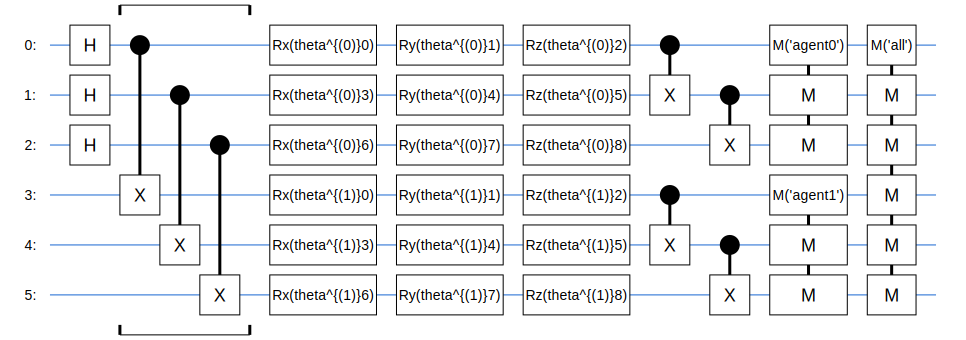

In [12]:
## Show example circuit architecture for the simple single-variational layer parameterized policy.
circuit, symbols = build_parameterized_system_circuit(
    d=3,
    n=2,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=1, symbol_superscript_index=aidx),
    entangle_fn=entangle_agents_phi_plus,
    meas_key_all='all',
    meas_key_prefix_agent='agent',
)
SVGCircuit(circuit)

### More complex parameterized variational + encoding policy

Contains variational layers with Rx, Ry, Rz rotations parameterized by $\theta$, followed by a next-neighbor entanglement layer, followed by an encoding layer to encode the state $s$. The final layer in the circuit is a variational layer.

In [13]:
def parameterized_variational_encoding_policy_circuit(
    qubits: list,
    n_layers: int,
    n_var_rotations: int = 3, # Number of rotational gates to apply for each qubit in the variational layer (e.g., Rx, Ry, Rz).
    variational_layer_fn: Callable[[list[cirq.LineQubit], list[list[float]]], Any] = variational_rotation_layer,
    entangling_layer_fn: Callable[[list[cirq.LineQubit]], Any] = lambda qubits: circular_entangling_layer(qubits, gate=cirq.CZ),
    encoding_layer_fn: Callable[[list[cirq.LineQubit], list[float]], Any] = lambda qubits, symbols: single_rotation_encoding_layer(qubits, symbols, gate=cirq.rx),
    symbol_superscript_index: int = None
    ) -> tuple[Callable[[], Iterable[Any]], list[list]]:
    d = len(qubits) # Dimension of qubits.
    
    # Variational parameters.
    var_thetas = sympy.symbols(f"theta{f'^{{({symbol_superscript_index})}}' if symbol_superscript_index is not None else ''}(0:{n_var_rotations*(n_layers+1)*d})") # Add +1 here because there will be a final variational layer at the end.
    var_thetas = np.asarray(var_thetas).reshape((n_layers+1, d, n_var_rotations))
    
    # Encoding parameters.
    enc_inputs = sympy.symbols(f"x{f'^{{({symbol_superscript_index})}}' if symbol_superscript_index is not None else ''}(0:{n_layers})_(0:{d})")
    enc_inputs = np.asarray(enc_inputs).reshape((n_layers, d))
    
    # Define generator to build circuit.
    # This allows the caller to define circuit parameters.
    def gen_circuit() -> Iterable[Any]:
        for l in range(n_layers):
            # Variational layer.
            yield variational_layer_fn(qubits, var_thetas[l])
            yield entangling_layer_fn(qubits)
            
            # Encoding layer.
            yield encoding_layer_fn(qubits, enc_inputs[l])
            
        # Last variational layer at the end.
        yield variational_layer_fn(qubits, var_thetas[n_layers])
    
    return gen_circuit, (var_thetas.flatten().tolist(), enc_inputs.flatten().tolist())

## Define parameter resolvers for this variational + encoding policy.

class ParamResolverRandomThetaRandomS:
    def __call__(self, symbols: list[list[sympy.Symbol]]):
        """Resolver for random variational thetas and random encoder inputs."""
        var_thetas_matrix, enc_inputs_matrix = zip(*symbols) # Unpack list of tuples to tuple of lists.
        var_thetas_matrix = np.asarray(var_thetas_matrix)
        enc_inputs_matrix = np.asarray(enc_inputs_matrix)
        var_thetas_values = np.random.uniform(low=0., high=np.pi, size=var_thetas_matrix.shape)
        enc_inputs_values = np.random.uniform(low=0., high=np.pi, size=enc_inputs_matrix.shape)
        param_dict = {
            **{symbol: var_thetas_values.flatten()[i] for i, symbol in enumerate(var_thetas_matrix.flatten())},
            **{symbol: enc_inputs_values.flatten()[i] for i, symbol in enumerate(enc_inputs_matrix.flatten())},
        }
        return param_dict

class ParamResolverIdenticalThetaIdenticalS:
    """Resolver for identical variational thetas and identical encoder inputs.
    
    This is written as a class that overloads `__call__` to act like a function because the function needs to define the random values based on the shape of the inputs the first time it is called.
    """
    def __init__(self):
        self.var_thetas_values = None
        self.enc_inputs_values = None

    def __call__(self, symbols: list[list[sympy.Symbol]]):
        var_thetas_matrix, enc_inputs_matrix = zip(*symbols) # Unpack list of tuples to tuple of lists.
        var_thetas_matrix = np.asarray(var_thetas_matrix)
        enc_inputs_matrix = np.asarray(enc_inputs_matrix)
        if self.var_thetas_values is None:
            self.var_thetas_values = np.random.uniform(low=0., high=np.pi, size=var_thetas_matrix.shape)
        if self.enc_inputs_values is None:
            self.enc_inputs_values = np.random.uniform(low=0., high=np.pi, size=enc_inputs_matrix.shape)
        param_dict = {
            **{symbol: self.var_thetas_values.flatten()[i] for i, symbol in enumerate(var_thetas_matrix.flatten())},
            **{symbol: self.enc_inputs_values.flatten()[i] for i, symbol in enumerate(enc_inputs_matrix.flatten())},
        }
        return param_dict

class ParamResolverNearlyIdenticalThetaIdenticalS:
    """Resolver for nearly identical variational thetas and identical encoder inputs.
    
    This is written as a class that overloads `__call__` to act like a function because the function needs to define the random values based on the shape of the inputs the first time it is called.
    """
    def __init__(self):
        self.var_thetas_values = None
        self.enc_inputs_values = None

    def __call__(self, symbols: list[list[sympy.Symbol]]):
        var_thetas_matrix, enc_inputs_matrix = zip(*symbols) # Unpack list of tuples to tuple of lists.
        var_thetas_matrix = np.asarray(var_thetas_matrix)
        enc_inputs_matrix = np.asarray(enc_inputs_matrix)
        if self.var_thetas_values is None:
            self.var_thetas_values = np.random.uniform(low=0., high=np.pi, size=var_thetas_matrix.shape)
        thetas_offset = np.random.uniform(low=0., high=0.5, size=var_thetas_matrix.shape) # Random theta offset (so that thetas between runs are nearly identical).
        if self.enc_inputs_values is None:
            self.enc_inputs_values = np.random.uniform(low=0., high=np.pi, size=enc_inputs_matrix.shape)
        param_dict = {
            **{symbol: (self.var_thetas_values + thetas_offset).flatten()[i] for i, symbol in enumerate(var_thetas_matrix.flatten())},
            **{symbol: self.enc_inputs_values.flatten()[i] for i, symbol in enumerate(enc_inputs_matrix.flatten())},
        }
        return param_dict

class ParamResolverNearlyIdenticalThetaRandomS:
    """Resolver for nearly identical variational thetas and random encoder inputs.
    
    This is written as a class that overloads `__call__` to act like a function because the function needs to define the random values based on the shape of the inputs the first time it is called.
    """
    def __init__(self):
        self.var_thetas_values = None
        self.enc_inputs_values = None

    def __call__(self, symbols: list[list[sympy.Symbol]]):
        var_thetas_matrix, enc_inputs_matrix = zip(*symbols) # Unpack list of tuples to tuple of lists.
        var_thetas_matrix = np.asarray(var_thetas_matrix)
        enc_inputs_matrix = np.asarray(enc_inputs_matrix)
        if self.var_thetas_values is None:
            self.var_thetas_values = np.random.uniform(low=0., high=np.pi, size=var_thetas_matrix.shape)
        thetas_offset = np.random.uniform(low=0., high=0.5, size=var_thetas_matrix.shape) # Random theta offset (so that thetas between runs are nearly identical).
        self.enc_inputs_values = np.random.uniform(low=0., high=np.pi, size=enc_inputs_matrix.shape) # Random state encoding values.
        param_dict = {
            **{symbol: (self.var_thetas_values + thetas_offset).flatten()[i] for i, symbol in enumerate(var_thetas_matrix.flatten())},
            **{symbol: self.enc_inputs_values.flatten()[i] for i, symbol in enumerate(enc_inputs_matrix.flatten())},
        }
        return param_dict

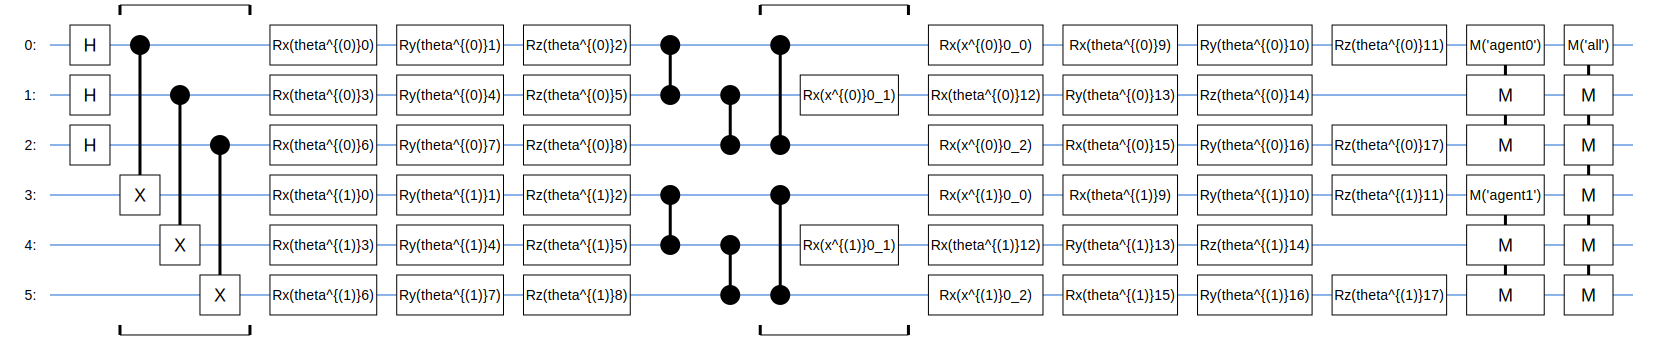

In [14]:
## Show example circuit architecture for the more advanced parameterized policy.
circuit, symbols = build_parameterized_system_circuit(
    d=3,
    n=2,
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=1, symbol_superscript_index=aidx),
    entangle_fn=entangle_agents_phi_plus,
    meas_key_all='all',
    meas_key_prefix_agent='agent',
)
SVGCircuit(circuit)

## Experiments

In [15]:
d_qubits = 2
n_agents = 2
n_layers = 1
repetitions = 1000
nrows, ncols = 3, 3

### Simple policy with CNOT variational entanglement

No encoding layers, just a single variational layer with next-neighbor qubit entanglement using CNOT gate.

In [16]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy, {n_agents} agents, {d_qubits} qubits per agent\ninput state $|0\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=None,
)

In [17]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy, {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=entangle_agents_phi_plus,
)

In [18]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy, {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=entangle_agents_psi_plus,
)

In [19]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy, {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^-\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=entangle_agents_psi_minus,
)

In [20]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy, {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^-\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=entangle_agents_phi_minus,
)

### Simple policy with CZ variational entanglement

No encoding layers, just a single variational layer with next-neighbor qubit entanglement using CZ gate.

In [21]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy (CZ next-neighbor variational entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx, entangling_layer_fn=lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CZ)),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=entangle_agents_phi_plus,
)

In [22]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy (CZ next-neighbor variational entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx, entangling_layer_fn=lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CZ)),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=entangle_agents_psi_plus,
)

In [23]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy (CZ next-neighbor variational entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^-\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx, entangling_layer_fn=lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CZ)),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=entangle_agents_psi_minus,
)

In [24]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy (CZ next-neighbor variational entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^-\\rangle$, random $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx, entangling_layer_fn=lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CZ)),
    symbol_resolver_fn=ParamResolverRandomTheta(),
    entangle_fn=entangle_agents_phi_minus,
)

In [25]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy (CZ next-neighbor variational entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, nearly identical $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx, entangling_layer_fn=lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CZ)),
    symbol_resolver_fn=ParamResolverNearlyIdenticalTheta(),
    entangle_fn=entangle_agents_phi_plus,
)

In [26]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy (CZ next-neighbor variational entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, nearly identical $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx, entangling_layer_fn=lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CZ)),
    symbol_resolver_fn=ParamResolverNearlyIdenticalTheta(),
    entangle_fn=entangle_agents_psi_plus,
)

In [27]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy (CZ next-neighbor variational entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^-\\rangle$, nearly identical $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx, entangling_layer_fn=lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CZ)),
    symbol_resolver_fn=ParamResolverNearlyIdenticalTheta(),
    entangle_fn=entangle_agents_phi_minus,
)

In [28]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nSimple Policy (CZ next-neighbor variational entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^-\\rangle$, nearly identical $\\theta$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    plot_agent_histogram=False,
    policy_fn=lambda qubits, aidx: parameterized_variational_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx, entangling_layer_fn=lambda qubits: neighbor_entangling_layer(qubits, gate=cirq.CZ)),
    symbol_resolver_fn=ParamResolverNearlyIdenticalTheta(),
    entangle_fn=entangle_agents_psi_minus,
)

### Advanced Parameterized Circuits

Includes variational and encoding layers.

#### Random $\theta$, Random $s$

In [29]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|0\\rangle$, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
    entangle_fn=None,
)

In [30]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
    entangle_fn=entangle_agents_phi_plus,
)

In [31]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
    entangle_fn=entangle_agents_psi_plus,
)

In [32]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^-\\rangle$, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
    entangle_fn=entangle_agents_psi_minus,
)

In [33]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^-\\rangle$, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
    entangle_fn=entangle_agents_phi_minus,
)

#### Identical $\theta$, Identical $s$

In [34]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_phi_plus,
)

In [35]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_psi_plus,
)

In [36]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^-\\rangle$, identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_psi_minus,
)

In [37]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^-\\rangle$, identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_phi_minus,
)

#### Nearly Identical $\theta$, Identical $s$

In [38]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, nearly identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_phi_plus,
)

In [39]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, nearly identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_psi_plus,
)

In [40]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^-\\rangle$, nearly identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_psi_minus,
)

In [41]:
test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^-\\rangle$, nearly identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_phi_minus,
)

## Run some experiments and save plot figures as files

In [42]:
basepath = Path('./images/')
basepath.mkdir(exist_ok=True)

In [43]:
plt.close()

In [44]:
## No Entanglement

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|0\\rangle$, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
    entangle_fn=None,
)
if fig is not None: fig.savefig(basepath/'no_entanglement_random_theta_random_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|0\\rangle$, identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverIdenticalThetaIdenticalS(),
    entangle_fn=None,
)
if fig is not None: fig.savefig(basepath/'no_entanglement_identical_theta_identical_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|0\\rangle$, nearly identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaIdenticalS(),
    entangle_fn=None,
)
if fig is not None: fig.savefig(basepath/'no_entanglement_nearly_identical_theta_identical_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|0\\rangle$, nearly identical $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaRandomS(),
    entangle_fn=None,
)
if fig is not None: fig.savefig(basepath/'no_entanglement_nearly_identical_theta_random_s.png')

In [45]:
## Phi+

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
    entangle_fn=entangle_agents_phi_plus,
)
if fig is not None: fig.savefig(basepath/'entangled_phi_plus_random_theta_random_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_phi_plus,
)
if fig is not None: fig.savefig(basepath/'entangled_phi_plus_identical_theta_identical_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, nearly identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_phi_plus,
)
if fig is not None: fig.savefig(basepath/'entangled_phi_plus_nearly_identical_theta_identical_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Phi^+\\rangle$, nearly identical $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaRandomS(),
    entangle_fn=entangle_agents_phi_plus,
)
if fig is not None: fig.savefig(basepath/'entangled_phi_plus_nearly_identical_theta_random_s.png')

In [46]:
## Psi+

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
    entangle_fn=entangle_agents_psi_plus,
)
if fig is not None: fig.savefig(basepath/'entangled_psi_plus_random_theta_random_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_psi_plus,
)
if fig is not None: fig.savefig(basepath/'entangled_psi_plus_identical_theta_identical_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, nearly identical $\\theta$, identical $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaIdenticalS(),
    entangle_fn=entangle_agents_psi_plus,
)
if fig is not None: fig.savefig(basepath/'entangled_psi_plus_nearly_identical_theta_identical_s.png')

fig = test_runner(
    d=d_qubits, n=n_agents,
    repetitions=repetitions,
    figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
    subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
    figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state $|\Psi^+\\rangle$, nearly identical $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    symbol_resolver_fn=ParamResolverNearlyIdenticalThetaRandomS(),
    entangle_fn=entangle_agents_psi_plus,
)
if fig is not None: fig.savefig(basepath/'entangled_psi_plus_nearly_identical_theta_random_s.png')

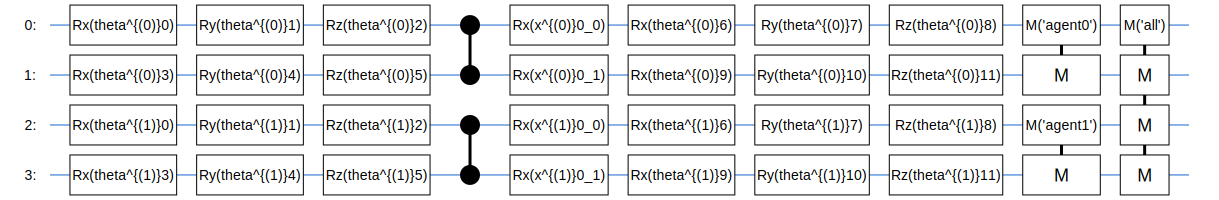

In [47]:
## Show example circuit.
circuit, _ = build_parameterized_system_circuit(
    d=d_qubits,
    n=n_agents,
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    entangle_fn=None,
    meas_key_all='all',
    meas_key_prefix_agent='agent',
)
svg = circuit_to_svg(circuit)
with open(basepath/f"pqc_{n_agents}_agents_{d_qubits}_qubits_{n_layers}_layers_no_entanglement.svg", '+w') as f:
    f.write(svg)
SVGCircuit(circuit)

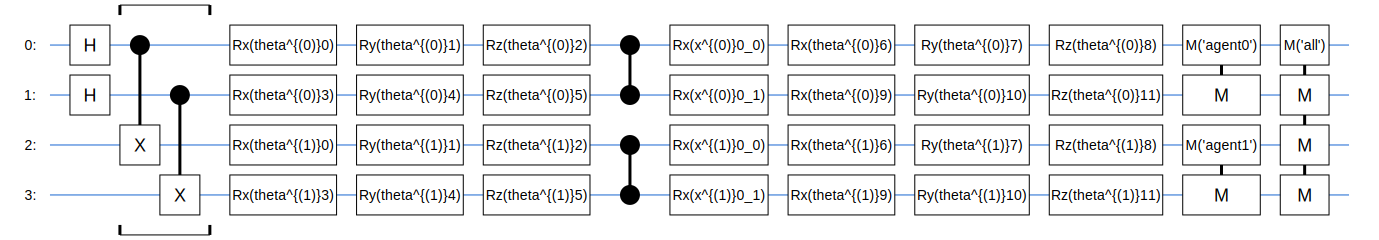

In [48]:
## Show example circuit.
circuit, _ = build_parameterized_system_circuit(
    d=d_qubits,
    n=n_agents,
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    entangle_fn=entangle_agents_phi_plus,
    meas_key_all='all',
    meas_key_prefix_agent='agent',
)
svg = circuit_to_svg(circuit)
with open(basepath/f"pqc_{n_agents}_agents_{d_qubits}_qubits_{n_layers}_layers_entangled_phi_plus.svg", '+w') as f:
    f.write(svg)
SVGCircuit(circuit)

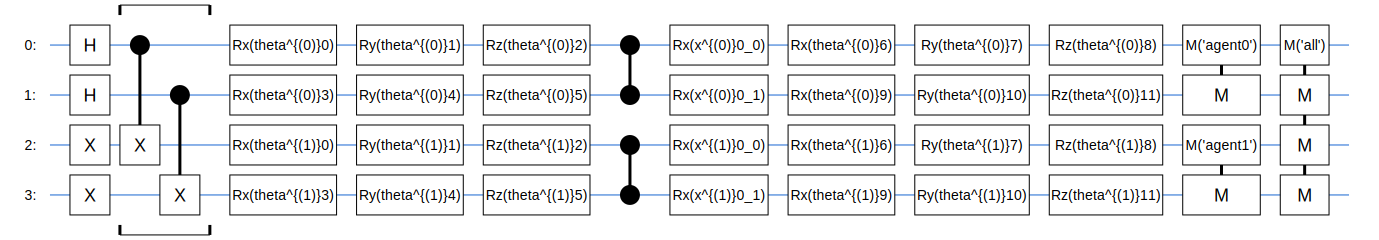

In [49]:
## Show example circuit.
circuit, _ = build_parameterized_system_circuit(
    d=d_qubits,
    n=n_agents,
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    entangle_fn=entangle_agents_psi_plus,
    meas_key_all='all',
    meas_key_prefix_agent='agent',
)
svg = circuit_to_svg(circuit)
with open(basepath/f"pqc_{n_agents}_agents_{d_qubits}_qubits_{n_layers}_layers_entangled_psi_plus.svg", '+w') as f:
    f.write(svg)
SVGCircuit(circuit)

Entanglement Type | Random $\theta$, Random $s$ | Identical $\theta$, Identical $s$ | Nearly Identical $\theta$, Identical $s$ | Nearly Identical $\theta$, Random $s$
------------------| ----------------------------| --------------------------------- | ---------------------------------------- | -------------------------------------
None | ![](images/no_entanglement_random_theta_random_s.png?raw=true) | ![](images/no_entanglement_identical_theta_identical_s.png?raw=true) | ![](images/no_entanglement_nearly_identical_theta_identical_s.png?raw=true) | ![](images/no_entanglement_nearly_identical_theta_random_s.png?raw=true)
$\ket{\Phi^{+}}$ | ![](images/entangled_phi_plus_random_theta_random_s.png?raw=true) | ![](images/entangled_phi_plus_identical_theta_identical_s.png?raw=true) | ![](images/entangled_phi_plus_nearly_identical_theta_identical_s.png?raw=true) | ![](images/entangled_phi_plus_nearly_identical_theta_random_s.png?raw=true)
$\ket{\Psi^{+}}$ | ![](images/entangled_psi_plus_random_theta_random_s.png?raw=true) | ![](images/entangled_psi_plus_identical_theta_identical_s.png?raw=true) | ![](images/entangled_psi_plus_nearly_identical_theta_identical_s.png?raw=true) | ![](images/entangled_psi_plus_nearly_identical_theta_random_s.png?raw=true)

## Various entanglement states

### Eigenvectors of the policy unitary

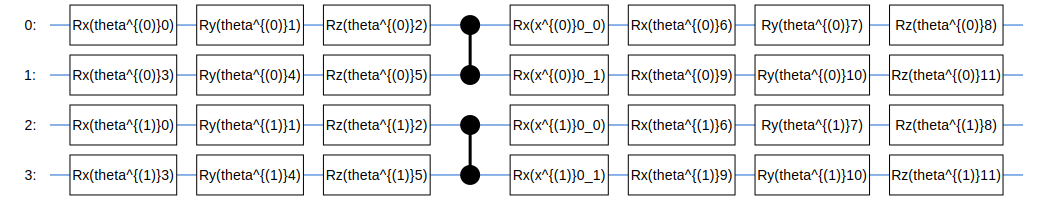

In [59]:
# Create parameterized circuit.
circuit, symbols = build_parameterized_system_circuit(
    d=2,
    n=2,
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=1, symbol_superscript_index=aidx),
    entangle_fn=None,
    meas_flag=False, # Do not measure.
)
SVGCircuit(circuit)

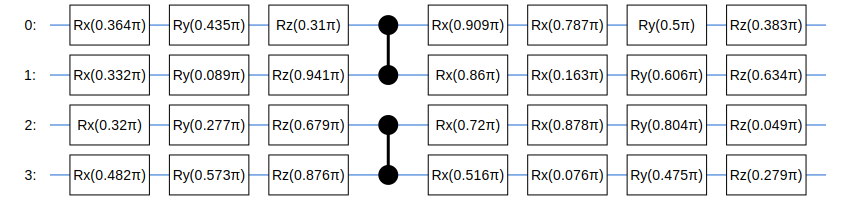

In [60]:
# Resolve symbols to concrete values.
symbol_resolver_fn = ParamResolverRandomThetaRandomS()
circuit_resolved = cirq.resolve_parameters(circuit, param_resolver=cirq.ParamResolver(symbol_resolver_fn(symbols)))
SVGCircuit(circuit_resolved)

In [63]:
U = cirq.unitary(circuit_resolved)
U.shape

(16, 16)

In [80]:
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.

In [84]:
eig_vects[:,0]

array([ 0.33780131-0.07764702j, -0.15893157+0.02681728j,
        0.0935777 +0.04545073j,  0.48938106-0.06652079j,
       -0.20720147-0.02490074j,  0.09550473+0.01721897j,
       -0.04374358-0.04483159j, -0.29080346-0.06211572j,
        0.24351567-0.26484199j, -0.1202766 +0.11629044j,
        0.10678359-0.01605651j,  0.37978366-0.3443398j ,
       -0.07923015+0.0171407j ,  0.0372476 -0.00579266j,
       -0.02174666-0.01091069j, -0.11464422+0.01408225j])

In [128]:
# Superposition of first and last eigenvector.
psi = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
psi.shape

(16,)

In [101]:
np.linalg.norm(psi) # Check normalization.

1.0

In [102]:
rho = cirq.density_matrix_from_state_vector(psi) # Build density matrix for entangled state.
rho.shape

(16, 16)

4


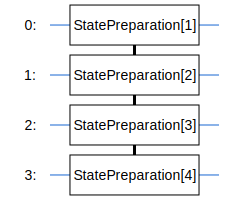

In [120]:
qubits = cirq.LineQubit.range(n_agents * d_qubits)
print(len(qubits))
circuit_prep = cirq.Circuit()
circuit_prep.append(cirq.StatePreparationChannel(target_state=psi)(*qubits))

SVGCircuit(circuit_prep)

In [129]:
rho_prep = cirq.final_density_matrix(circuit_prep)
rho_prep.shape

(16, 16)

In [130]:
np.allclose(rho_prep, rho)

True

In [141]:
def extract_unitary_from_parameterized_circuit(
    circuit: cirq.Circuit,
    symbol_list: list[list[list[sympy.Symbol]]] = None,
    symbol_resolver_fn: Callable[..., dict] = None,
    ) -> np.ndarray:
    """Constructs a unitary matrix that represents the given circuit.
    
    Provided circuit can either be parameterized or static (i.e., no symbols). If parameterized, then a symbol list and symbol resolver function is required.
    """

    # Default resolver returns empty dictionary.
    if symbol_resolver_fn is None:
        symbol_resolver_fn = lambda *args, **kwargs: {}

    # Resolve symbols to concrete values.
    symbol_dict = symbol_resolver_fn(symbol_list)

    # Create a new circuit with concrete parameter values.
    circuit_resolved = cirq.resolve_parameters(circuit, param_resolver=cirq.ParamResolver(symbol_dict))

    # Extract unitary from resolved circuit.
    U = cirq.unitary(circuit_resolved)
    return U

In [137]:
# Extract unitary from parameterized circuit.
U_new = extract_unitary_from_parameterized_circuit(circuit, symbols, symbol_resolver_fn=ParamResolverRandomThetaRandomS())

In [139]:
# Extract unitary from static circuit (no symbols).
U_new = extract_unitary_from_parameterized_circuit(circuit_resolved)

In [140]:
np.allclose(U_new, U)

True